# Tutorial: Quantum Annealing Libraries

This tutorial demonstrates the functionalities of two Python libraries:
- `library_annealing_comm`: Quantum annealing protocols for Ising models
- `library_measurments_comm`: Correlation function measurements


In [2]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from qlmaas.qpus import AnalogQPU, MPSTraj
from qat.core import Observable, Term

# Import custom annealing and measurement libraries
import library_annealing as ann
import library_measurments as mes


## Ising Chain Hamiltonian

Our Hamiltonian of interest is the Ising Chain in a transverse field with ferromagnetic interaction (J < 0). The system is regulated by four parameters:
- System size (number of spins)
- Transverse field h
- Ising interaction J
- Periodicity (boundary conditions)

This model exhibits a second-order phase transition at |h| = |J|, separating ferromagnetic and paramagnetic phases.


In [3]:
# Define Hamiltonian parameters
nbspins = 4  # Number of spins in the chain
h = 2  # Transverse field strength
J = -1  # Ferromagnetic coupling (negative)
periodic = True  # Periodic boundary conditions

# Build the Ising Hamiltonian components
operators, positions, coeff = ann.write_ising_ham(nbspins, h, J, periodic)

# Construct the observable from terms
terms_hamiltonian = [
    Term(coeff[i], operators[i], positions[i])
    for i in range(len(operators))
]
hamiltonian = Observable(nbspins, pauli_terms=terms_hamiltonian)

# Display the Hamiltonian
print(hamiltonian)


2 * (Z|[0]) +
2 * (Z|[1]) +
2 * (Z|[2]) +
2 * (Z|[3]) +
-1 * (XX|[0, 1]) +
-1 * (XX|[1, 2]) +
-1 * (XX|[2, 3]) +
-1 * (XX|[3, 0])


## Quantum Annealing Protocol

Our goal is to reach a ground state of the Hamiltonian for generic interaction parameters (h, J).

The quantum annealing protocol:
1. Start with an easy-to-prepare ground state (e.g., |1111⟩, J=0)
2. Slowly change the interaction parameters to always follow the instantaneous ground state
3. If the evolution is too fast, we generate excitations (defects)

The speed of evolution is controlled by parameter τ (tau): larger τ = slower evolution = fewer defects.


In [9]:
# Define target Hamiltonian and annealing speed
nbspins = 4
h_target = 2
j_target = -1
periodic = True
tau = 2  # Annealing speed parameter

# Initialize high-precision QPU
qpu = AnalogQPU(abs_tol=10**(-8), rel_tol=10**(-8))

# Prepare the target state using quantum annealing
res = ann.prepare_state(nbspins, h_target, j_target, periodic, tau, qpu)

# Print the final state
for sample in res:
    print(sample.state,'\t',sample.amplitude)


Submitted a new batch: SJob85672
|0000> 	 (-0.7706655654823468+0.5785570522261758j)
|0011> 	 (0.09729677545706863-0.08003614122334012j)
|0101> 	 (-0.03729920337892298+0.045801462090913375j)
|0110> 	 (0.09729677545706865-0.08003614122334013j)
|1001> 	 (0.0972967754570686-0.08003614122334016j)
|1010> 	 (-0.03729920337892298+0.04580146209091337j)
|1100> 	 (0.09729677545706865-0.08003614122334013j)
|1111> 	 (-0.022944036820236813+0.01876025617839438j)


## State Quality Estimation

Since we don't know the final ground state a priori, we need a metric for how close we are to the target.

We measure this by counting the **density of excitations** (defects) generated by the protocol.
The method: evolve to the target Hamiltonian and return back. If no excitations are generated, we've followed the ground state perfectly.


In [5]:
# Estimate the quality of the prepared state
quality = ann.estimate_state_quality(nbspins, h_target, j_target, periodic, tau, qpu)
print(f"Defect density: {quality}")
# Lower is better - ideally should be zero


Submitted a new batch: SJob85668
Defect density: 0.002046622047877089


## Observable Measurements

To understand the physical behavior of the system, we measure observables such as:
- Total magnetization
- Correlation functions

After reaching a target state, we compute these physical quantities.


In [6]:
# Example: Start from paramagnetic phase (J=0) with all spins aligned
nbspins = 4
h_target = 2
j_target = 0  # No coupling (sanity check - no evolution)
periodic = True
tau = 2

# Initial state: all spins down (|1111⟩)
psi_in = '1' * nbspins

# Build schedule for paramagnetic annealing
schedule_go = ann.sched_go_para(nbspins, h_target, j_target, periodic, tau)

# Measure one-point correlation in Z basis for all spins
direction = 'Z'
list_position = [i for i in range(nbspins)]
values = mes.one_point_corr(schedule_go, direction, list_position, qpu, psi_in)

print(f"One-point correlations <Z_i>: {values}")


Submitted a new batch: SJob85669
One-point correlations <Z_i>: [-1. -1. -1. -1.]


In [7]:
# Measure for a generic Hamiltonian with finite coupling
nbspins = 4
h_target = 2
j_target = -1  # Ferromagnetic coupling
periodic = True
tau = 2

# Initial state
psi_in = '1' * nbspins

# Build schedule
schedule_go = ann.sched_go_para(nbspins, h_target, j_target, periodic, tau)

# Measure one-point correlation
direction = 'Z'
list_position = [i for i in range(nbspins)]
values = mes.one_point_corr(schedule_go, direction, list_position, qpu, psi_in)

print(f"One-point correlations: {values}")


Submitted a new batch: SJob85670
One-point correlations: [-0.9277753 -0.9277753 -0.9277753 -0.9277753]


In [8]:
# Measure two-point correlation function XX between neighboring sites
nbspins = 4
h_target = 2
j_target = -1
periodic = True
tau = 2

# Initial state
psi_in = '1' * nbspins

# Build schedule
schedule_go = ann.sched_go_para(nbspins, h_target, j_target, periodic, tau)

# Measure XX correlation in X basis
direction = 'X'
# Include periodic boundary term [3,0] plus nearest neighbors
list_position = [[nbspins - 1, 0]] + [[i, i + 1] for i in range(nbspins - 1)]
values = mes.two_point_corr(schedule_go, direction, list_position, qpu, psi_in)

print(f"Two-point correlations <X_i X_{{i+1}}>: {values}")


Submitted a new batch: SJob85671
Two-point correlations <X_i X_{i+1}>: [0.27922471 0.27922471 0.27922471 0.27922471]


## Evolution Across the Phase Transition

We now examine how observables evolve at fixed τ as we change the ratio h/J.

**Key observation**: Near |h| ≈ |J| (critical point), we need longer evolution times for stable results. The gap between ground and excited states shrinks, creating more excitations at equal τ.


In [12]:
# Scan the paramagnetic phase: |h_target| > |J_target|
nbspins = 4
h_target_para = np.array([1.1, 1.3, 1.5, 2])  # Multiple h values (paramagnetic)
j_target = -1
periodic = True
tau = 1.5

# Initial state: all spins down
psi_in = '1' * nbspins

# Initialize result array
mean_xx_para = np.zeros(len(h_target_para))

# Measurement parameters
direction = 'X'
list_position = [[nbspins - 1, 0]] + [[i, i + 1] for i in range(nbspins - 1)]

# Build the list of schedules and initial states for the batch
list_sched = []
list_psi_in = []
# Loop over h values
for i in range(len(h_target_para)): 
    list_sched.append(ann.sched_go_para(
        nbspins,h_target_para[i],j_target,periodic,tau
    ))
    list_psi_in.append(psi_in)
values = mes.two_point_corr_batch(list_sched,direction,list_position,qpu,list_psi_in)
mean_xx_para = np.mean(values,1)


Submitted a new batch: SJob85676


In [13]:
# Scan the ferromagnetic phase: |h_target| < |J_target|
nbspins = 4
h_target_ferro = np.array([0.1, 0.3, 0.5, 0.6, 0.9])  # Multiple h values (ferro)
j_target = -1
periodic = True
tau = 1.5

# Initial state: symmetric superposition of all-up and all-down
psi_in = np.zeros(2**nbspins)
psi_in[0] = 1 / np.sqrt(2)  # |0000⟩
psi_in[-1] = 1 / np.sqrt(2)  # |1111⟩

# Initialize result array
mean_xx_ferro = np.zeros(len(h_target_ferro))

# Measurement parameters
direction = 'X'
list_position = [[nbspins - 1, 0]] + [[i, i + 1] for i in range(nbspins - 1)]


list_sched=[]
list_psi_in=[]
# Loop over h values
for i in range(len(h_target_ferro)):  
    #We have to do a rotation to go into the "+" and "-" basis so we have to pipe two schedules
    schedule_rot = ann.sched_rot(-np.pi/4,'Y',nbspins)
    schedule_go = ann.sched_go_ferro(
        nbspins,h_target_ferro[i],j_target,periodic,tau
    )
    schedule_final = schedule_rot | schedule_go
    list_sched.append(schedule_final)
    list_psi_in.append(psi_in)
values = mes.two_point_corr_batch(list_sched,direction,list_position,qpu,list_psi_in)
mean_xx_ferro = np.mean(values,1)


Submitted a new batch: SJob85677


In [14]:
# Combine results from both phases
h_target = np.concatenate((h_target_ferro, h_target_para))
mean_xx = np.concatenate((mean_xx_ferro, mean_xx_para))


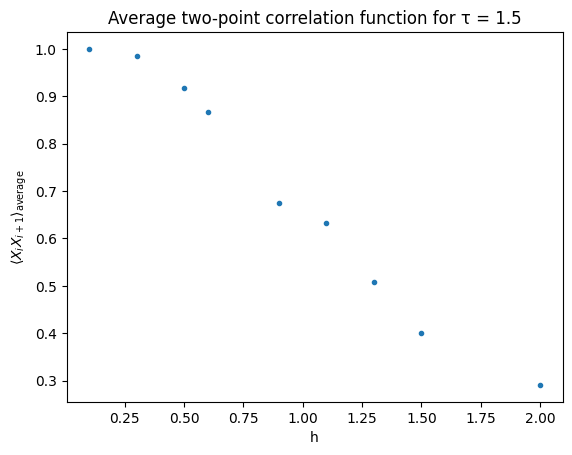

In [15]:
# Plot average two-point correlation function vs h
plt.figure(1)
plt.plot(h_target, mean_xx, '.')
plt.xlabel('h')
plt.ylabel(r'$\langle X_i X_{i+1} \rangle_{\mathrm{average}}$')
plt.title(f'Average two-point correlation function for τ = {tau}')
plt.show()


In [16]:
# Estimate state quality across all h values using batch processing
nbspins = 4
j_target_array = -1 * np.ones(len(h_target))  # Same J for all
periodic = True
tau = 1.5

# Run batch estimation
defects = ann.estimate_state_quality_batch(
    nbspins, h_target, j_target_array, periodic, tau, qpu
)

#print(f"Defect densities: {defects}")


Submitted a new batch: SJob85678
Submitted a new batch: SJob85679
Defect densities: [0.00042363 0.02062403 0.05998954 0.07878096 0.10529458 0.0991658
 0.02759151 0.01626359 0.00958803]


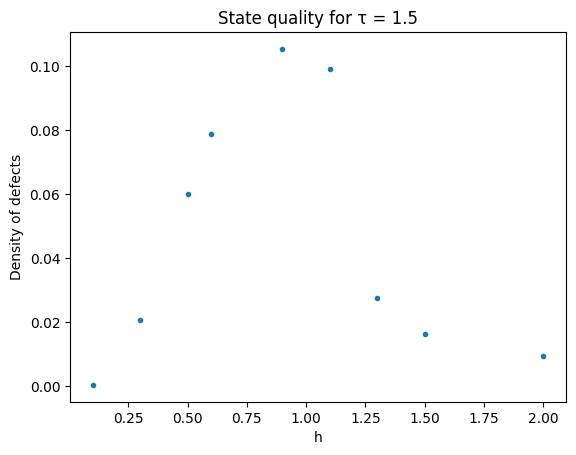

In [17]:
# Plot defect density vs h
# Near |h| ≈ |J|, protocols with same speed approximate ground state less well
plt.figure(2)
plt.plot(h_target, defects, '.')
plt.xlabel('h')
plt.ylabel('Density of defects')
plt.title(f'State quality for τ = {tau}')
plt.show()
